# Calibration silver bullet spectrometer

The original script has been written by Raphael Deirmendjian in 2022 (see Github: https://github.com/Rafale05/Silver-Bullet-calibration). The plotting routines have been updated regarding to the original file and it has been made into a Jupyter notebook.

In the cell below, the calibration data (both wavelength, background and absolute calibration) from the silver bullet spectrometer is processed (for more information see this Youtube video: https://youtu.be/WP0HZCWyedU). In addition, 5 plotting functions are defined, which you can choose after running the cell below.

The relevant functions are:
* Plot_raw
* Outlier_report_peirce
* Plot_norm
* Plot_std
* Plot_std_variation

If you want to plot the data for specific years (can be 1 or several), input the year as a list variable (e.g. Plot_raw([2021,2022]) ).

Otherwise, if you want to plot all available years, you can use: Plot_raw(all_years).

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
import scipy.special
from sklearn.metrics import r2_score
import time

##FUNCTIONS
## Read_Sorted returns a 381 wl containing X measurements of the same wavelength
def Read_Sorted(path,year):        
    path_final=path
    f=open(path_final,"r")
    data1=[]
    data2=[]
    for ligne in f:
        data1.append(ligne.strip().split())
    data1.pop(0)
    data1.pop(0)
    data1.pop(0)
    data1.pop(0)
    data1.pop(0)
    data1.pop(0)
    data1.pop(0)
    data1.pop(0)
    realdata=[]
    data2=[]
    for i in data1:
        if i[0]!=str(year):
            for k in i:
                data2.append(k)
        if i[0]==str(year):
            realdata.append(data2)
            data2=[]
    realdata.append(data2)
    realdata.pop(0)
    wl=np.linspace(8285,8706,381,True)
    values_sorted=[]
    for i in range (0,len(realdata[0])):
        values_sorted.append([int(realdata[0][i])])
    for i in range(1,len(realdata)):
        for k in range (0,len(realdata[i])):
            values_sorted[k].append(int(realdata[i][k]))
    return(values_sorted)

#Returns the adjusted wavelength tab depending on the .Cal file
def Adjustment(path):
    file=open(path)
    data_loc=[]
    for k in file :
        data_loc.append(k.strip())
    x0=float(data_loc[1])
    x1=float(data_loc[2])
    x2=float(data_loc[3])
    x3=float(data_loc[4])
    wl=np.linspace(0,381,381,True)
    adjusted_wl=[]
    for (i) in wl:
        adjusted_wl.append((x0+float(i)*x1+float(i)**2*x2+float(i)**3*x3))
        
    return(adjusted_wl)

##Calculate Peirce's coef (related to Peirce's criterion outlier treatment)
def peirce_dev(N: int, n: int, m: int) -> float:
    """Peirce's criterion
    
    Returns the squared threshold error deviation for outlier identification
    using Peirce's criterion based on Gould's methodology.
    
    Arguments:
        - int, total number of observations (N)
        - int, number of outliers to be removed (n)
        - int, number of model unknowns (m)
    Returns:
        float, squared error threshold (x2)
    """
    # Assign floats to input variables:
    N = float(N)
    n = float(n)
    m = float(m)

    # Check number of observations:
    if N > 1:
        # Calculate Q (Nth root of Gould's equation B):
        Q = (n ** (n / N) * (N - n) ** ((N - n) / N)) / N
        #
        # Initialize R values (as floats)
        r_new = 1.0
        r_old = 0.0  # <- Necessary to prompt while loop
        #
        # Start iteration to converge on R:
        while abs(r_new - r_old) > (N * 2.0e-16):
            # Calculate Lamda
            # (1/(N-n)th root of Gould's equation A'):
            ldiv = r_new ** n
            if ldiv == 0:
                ldiv = 1.0e-6
            Lamda = ((Q ** N) / (ldiv)) ** (1.0 / (N - n))
            # Calculate x-squared (Gould's equation C):
            x2 = 1.0 + (N - m - n) / n * (1.0 - Lamda ** 2.0)
            # If x2 goes negative, return 0:
            if x2 < 0:
                x2 = 0.0
                r_old = r_new
            else:
                # Use x-squared to update R (Gould's equation D):
                r_old = r_new
                r_new = np.exp((x2 - 1) / 2.0) * scipy.special.erfc(
                    np.sqrt(x2) / np.sqrt(2.0)
                )
    else:
        x2 = 0.0
    return np.sqrt(x2)

#Eliminates outliers using Peirce's criterion and returns additionnaly the amount
#of outliers and their standard deviation
def Peirce_crit(dataset):
    mean=statistics.mean(dataset)
    std=statistics.stdev(dataset)
    rang=1
    count=0
    std_count=[]
    newdata=dataset[:]
    while rang !=0:
        to_delete=[]
        R=peirce_dev(len(newdata),rang,1)
        dev_max=R*std
        for i in range (0,len(newdata)):
            dev=abs(newdata[i]-mean)
            if dev>dev_max:
                to_delete.append(i)
                std_count.append(abs((newdata[i]-mean)/std))
        if len(to_delete)==0:
            rang=0
        else:
            for k in reversed(to_delete):
                del newdata[k]
            rang=len(to_delete)+1
            count+=len(to_delete)
    return(newdata,count,std_count)

#Return an average tab 
def Average(dataset):
    average=[]
    for i in range (0,len(dataset)):
        average.append(statistics.mean(dataset[i]))
    return(average)

#Subtracts the bg from the abs cal
def Bg_subtraction(bg,abscal):
    result=[]
    for i in range(0,len(bg)):
        result.append(abscal[i]-bg[i])
    return(result)
#Calculates the known brightness 
def Cal_fact(r,R,rho,wl,alpha,cert):
        alpha_rad=(alpha*np.pi)/180
        return(rho*cert*((r/R)**2)*np.cos(alpha_rad))
    
#Plots the calibration factor
def Plot_raw(year):
    count=0
    snr=[]
    for i in year:
        path=dico["a"+str(i)]
        wl=Adjustment(path[2])
        bg=Read_Sorted(dico["a"+str(i)][0],int(i)) #raw file
        abscal=Read_Sorted(dico["a"+str(i)][1],int(i)) #raw file
        #outliers sorting with Peirce's crit
        bg_out=[]
        abscal_out=[]
        for ki in range(0,len(wl)):
            bg_out.append(Peirce_crit(bg[ki])[0])
            abscal_out.append(Peirce_crit(abscal[ki])[0])
        #averaging
        bg_m=[]
        abscal_m=[]
        for k in range(0,len(wl)):
            bg_m.append(statistics.mean(bg_out[k]))
            abscal_m.append(statistics.mean(abscal_out[k]))
        #truncate
        bot=8374
        top=8525
        bg_c=[]
        abscal_c=[]
        wl_c=[]
        for k in range(0,len(wl)):
            if wl[k]>=bot and wl[k]<=top:
                bg_c.append(bg_m[k])
                abscal_c.append(abscal_m[k])
                wl_c.append(wl[k])
        #Calculating the known brightness
        B=[]
        for k in range (0,len(wl_c)):
            B.append(Cal_fact(r,dicop["p"+str(i)][0],rho,wl[k],
                              dicop["p"+str(i)][1],synthetic_fit(wl_c[k])))
        k=[] #k=calibration factor
        for j in range (0,len(B)):
            k.append(B[j]/(abscal_c[j]-bg_c[j]))
        
        plt.scatter(wl_c,k,marker='+') #real plot
        #Interpolates
        fit=np.polyfit(wl_c,k,1,rcond=None,full=True)
        k_int=[]
        for l in wl_c:
            k_int.append(interpol(l,fit))
        r_2=r2_score(k,k_int)
        plt.plot(wl_c,k_int,
                 label=str(i)+' linear regression : '+str('%.3E' %fit[0][0])+
                 'x+' +str('%.3E' %fit[0][1] )+
                 ', r²='+str('%.2E' %r_2))
        count+=1
        snr.append(statistics.mean(abscal_c)/statistics.mean(bg_c))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #plt.title("Values filtered with Peirce's criterion")
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('C [R/Å/CTS]')
    #plt.savefig('NAME.png')
    plt.figure(2)
    plt.scatter(year,snr,color='black')
    plt.xlabel("years")
    plt.ylabel('SNR estimate')
    plt.show()
    #return("SNR values:", snr)

#Gives a report on the amount of outliers deleted
def Outlier_report_peirce(year):
    for i in year:
        path=dico["a"+str(i)]
        wl=Adjustment(path[2])
        bg=Read_Sorted(dico["a"+str(i)][0],int(i)) #raw file
        abscal=Read_Sorted(dico["a"+str(i)][1],int(i)) #raw file
        #outliers sorting with Peirce's crit
        bg_out=[]
        abscal_out=[]
        nb_bg=[]
        nb_abs=[]
        for ki in range(0,len(wl)):
            bg_out.append(Peirce_crit(bg[ki])[0])
            abscal_out.append(Peirce_crit(abscal[ki])[0])
            nb_bg.append(Peirce_crit(bg[ki])[1])
            nb_abs.append(Peirce_crit(abscal[ki])[1])
        plt.scatter(wl,nb_bg,label=str(i)+', background. '+
                    str(sum(nb_bg))+'/'+
                    str(len(bg[0] )*381)+' datapoints removed ('+ str(round(sum(nb_bg)/(len(bg[0])*381)*100,1))+'%)')
        plt.scatter(wl,nb_abs,label=str(i)+', absolute calibration. '+
                    str(sum(nb_abs))+'/'+
                    str(len(abscal[0] )*381)+' datapoints removed ('+ str(round(sum(nb_abs)/(len(abscal[0])*381)*100,1))+'%)')
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title("Outlier deletion report")
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('Deleted outliers [CTS]')
    plt.show()

#Gives a report on the standard deviation of the deleted outliers
def Outlier_report_peirce_std(year):
    for i in year:
        path=dico["a"+str(i)]
        wl=Adjustment(path[2])
        bg=Read_Sorted(dico["a"+str(i)][0],int(i)) #raw file
        abscal=Read_Sorted(dico["a"+str(i)][1],int(i)) #raw file
        #outliers sorting with Peirce's crit
        bg_out=[]
        abscal_out=[]
        dev_bg=[]
        dev_abs=[]
        for ki in range(0,len(wl)):
            for w in (Peirce_crit(bg[ki])[2]):
                dev_bg.append(w)
            for w in (Peirce_crit(abscal[ki])[2]):
                dev_abs.append(w)
        plt.hist(dev_bg,label=str(i)+', background ')
        plt.hist(dev_abs,label=str(i)+', absolute calibration ')
    plt.grid()
    plt.legend()
    plt.title("Outlier deletion report")
    plt.xlabel('Number of STD from mean [CTS]')
    plt.ylabel('Deleted outliers [CTS]')
    plt.show()  
      
#Plots the calibration factor, normalized at 8430 
def Plot_norm(year):
    norm=8430
    for i in year:
        path=dico["a"+str(i)]
        wl=Adjustment(path[2])
        bg=Read_Sorted(dico["a"+str(i)][0],int(i)) #raw file
        abscal=Read_Sorted(dico["a"+str(i)][1],int(i)) #raw file
        #outliers sorting with Peirce's crit
        bg_out=[]
        abscal_out=[]
        for ki in range(0,len(wl)):
            bg_out.append(Peirce_crit(bg[ki])[0]) 
            abscal_out.append(Peirce_crit(abscal[ki])[0])
        #averaging
        bg_m=[]
        abscal_m=[]
        for k in range(0,len(wl)):
            bg_m.append(statistics.mean(bg_out[k]))
            abscal_m.append(statistics.mean(abscal_out[k]))
        #truncate
        bot=8374
        top=8525
        bg_c=[]
        abscal_c=[]
        wl_c=[]
        for k in range(0,len(wl)):
            if wl[k]>=bot and wl[k]<=top:
                bg_c.append(bg_m[k])
                abscal_c.append(abscal_m[k])
                wl_c.append(wl[k])
        #Calculating the known brightness
        B=[]
        for k in range (0,len(wl_c)):
            B.append(Cal_fact(r,dicop["p"+str(i)][0],rho,wl[k],
                              dicop["p"+str(i)][1],synthetic_fit(wl_c[k])))
        k=[] #k=calibration factor
        for j in range (0,len(B)):
            k.append(B[j]/(abscal_c[j]-bg_c[j]))
        #Interpolates
        fit=np.polyfit(wl_c,k,1,rcond=None,full=True)
        # print(fit) #to print the fit values for the different years (the first value gives the slope)
        k_int=[]
        wl_b=np.linspace(bot,top,2)
        for l in wl_b:
            k_int.append(l*fit[0][0]+(1-(norm*fit[0][0])))
        plt.plot(wl_b,k_int,label=i)
        
    plt.grid()
    plt.legend()
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('C [R/Å/CTS]')
    #plt.savefig('norm_calibration_allyears.png')
    plt.show()
    
#Plots the std 
def Plot_std(year):
    bg_std=[]
    abs_std=[]
    count=0
    fig,axs=plt.subplots(2,2)
    avg_std_bg=[]
    avg_std_abs=[]
    for i in year:
        bg_std=[]
        abs_std=[]
        path=dico["a"+str(i)]
        wl=Adjustment(path[2])
        bg=Read_Sorted(dico["a"+str(i)][0],int(i)) #raw file
        abscal=Read_Sorted(dico["a"+str(i)][1],int(i)) #raw file
        #outliers sorting with Peirce's crit
        bg_out=[]
        abscal_out=[]
        bg_std_out=[]
        abs_std_out=[]
        for ki in range(0,len(wl)):
            bg_out.append(Peirce_crit(bg[ki])[0])
            abscal_out.append(Peirce_crit(abscal[ki])[0])
        #averaging
        bg_m=[]
        abscal_m=[]
        bg_out_m=[]
        abscal_out_m=[]
        for k in range(0,len(wl)):
            bg_m.append(statistics.mean(bg[k]))
            abscal_m.append(statistics.mean(abscal[k]))
            bg_std.append(statistics.stdev(bg[k]))
            abs_std.append(statistics.stdev(abscal[k]))
            bg_std_out.append(statistics.stdev(bg_out[k]))
            abs_std_out.append(statistics.stdev(abscal_out[k]))
        #truncate
        bot=8374
        top=8525
        bg_std_c=[]
        abs_std_c=[]
        wl_c=[]
        bg_std_out_c=[]
        abs_std_out_c=[]
        for k in range(0,len(wl)):
            if wl[k]>=bot and wl[k]<=top:
                bg_std_c.append(bg_std[k])
                abs_std_c.append(abs_std[k])
                abs_std_out_c.append(abs_std_out[k])
                bg_std_out_c.append(bg_std_out[k])
                wl_c.append(wl[k])

        avg_std_bg.append(statistics.mean(bg_std_c))
        avg_std_abs.append(statistics.mean(abs_std_c))
        
        axs[0,0].plot(wl_c,bg_std_c,label=str(i))
        axs[0,0].set_title('Background, outliers not treated')

        axs[1,0].plot(wl_c,bg_std_out_c,label=str(i))
        axs[1,0].set_title('Background, outliers treated')

        axs[0,1].plot(wl_c,abs_std_c,label=str(i))
        axs[0,1].set_title('Absolute calibration, outliers not treated')

        axs[1,1].plot(wl_c,abs_std_out_c,label=str(i))
        axs[1,1].set_title('Absolute calibration, outliers treated')
       
        count+=1
    for ax in axs.flat:
        ax.set(xlabel='Wavelength [Å]', ylabel='Standard deviation')
        ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    fig.tight_layout(pad=0.5)
    fig.set_size_inches(18.5, 10.5)

    plt.figure(2)
    plt.plot(year,avg_std_bg,label='Background')
    plt.plot(year,avg_std_abs,label='Absolute calibration')
    plt.ylabel('Standard deviation')
    plt.title('Outliers not treated')
    plt.xlabel("Years")
    plt.legend()
    plt.show()

#Plots the relative standard deviation
def Plot_std_variation(year):
    measurements_bg=[35,20,32,34,42,38,34,26,21,29,33]
    measurements_abs=[30,23,32,41,47,38,39,24,18,30,38]
    bg_std=[]
    abs_std=[]
    count=0
    fig,axs=plt.subplots(2,2)
    avg_std_bg=[]
    avg_std_abs=[]
    avg_std_out_bg=[]
    avg_std_out_abs=[]
    for i in year:
        bg_std=[]
        abs_std=[]
        path=dico["a"+str(i)]
        wl=Adjustment(path[2])
        bg=Read_Sorted(dico["a"+str(i)][0],int(i)) #raw file
        abscal=Read_Sorted(dico["a"+str(i)][1],int(i)) #raw file
        #outliers sorting with Peirce's crit
        bg_out=[]
        abscal_out=[]
        bg_std_out=[]
        abs_std_out=[]
        for ki in range(0,len(wl)):
            bg_out.append(Peirce_crit(bg[ki])[0])
            abscal_out.append(Peirce_crit(abscal[ki])[0])
        #averaging
        bg_m=[]
        abscal_m=[]
        bg_out_m=[]
        abscal_out_m=[]
        for k in range(0,len(wl)):
            bg_m.append(statistics.mean(bg[k]))
            abscal_m.append(statistics.mean(abscal[k]))
            bg_out_m.append(statistics.mean(bg_out[k]))
            abscal_out_m.append(statistics.mean(abscal_out[k]))
            bg_std.append(statistics.stdev(bg[k]))
            abs_std.append(statistics.stdev(abscal[k]))
            bg_std_out.append(statistics.stdev(bg_out[k]))
            abs_std_out.append(statistics.stdev(abscal_out[k]))
            
        #truncate
        bot=8374
        top=8525
        bg_std_c=[]
        abs_std_c=[]
        wl_c=[]
        bg_std_out_c=[]
        abs_std_out_c=[]
        for k in range(0,len(wl)):
            if wl[k]>=bot and wl[k]<=top:
                bg_std_c.append(bg_std[k]/bg_m[k])
                abs_std_c.append(abs_std[k]/abscal_m[k])
                abs_std_out_c.append(abs_std_out[k]/abscal_out_m[k])
                bg_std_out_c.append(bg_std_out[k]/bg_out_m[k])
                wl_c.append(wl[k])

        avg_std_bg.append(statistics.mean(bg_std_c))
        avg_std_abs.append(statistics.mean(abs_std_c))

        avg_std_out_bg.append(statistics.mean(bg_std_out_c))
        avg_std_out_abs.append(statistics.mean(abs_std_out_c))
        
        axs[0,0].plot(wl_c,bg_std_c,label=str(i))
        axs[0,0].set_title('Background, outliers not treated')

        axs[1,0].plot(wl_c,bg_std_out_c,label=str(i))
        axs[1,0].set_title('Background, outliers treated')

        axs[0,1].plot(wl_c,abs_std_c,label=str(i))
        axs[0,1].set_title('Absolute calibration, outliers not treated')

        axs[1,1].plot(wl_c,abs_std_out_c,label=str(i))
        axs[1,1].set_title('Absolute calibration, outliers treated')

        count+=1
    for ax in axs.flat:
        ax.set(xlabel='Wavelength [Å]', ylabel='Relative standard deviation')
        ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    fig.tight_layout(pad=0.5)
    fig.set_size_inches(18.5, 10.5)
        
    plt.figure(2)
    plt.plot(year,avg_std_bg,label='Background')
    plt.plot(year,avg_std_abs,label='Absolute calibration')
    plt.ylabel('Relative standard deviation')
    plt.title('Ouliers not removed')
    plt.xlabel("Years")
    plt.legend()
    plt.figure(3)
    plt.plot(year,avg_std_out_bg,label='Background')
    plt.plot(year,avg_std_out_abs,label='Absolute calibration')
    plt.title("Outliers removed")
    plt.ylabel('Relative standard deviation')
    plt.xlabel("Years")
    plt.legend()
    plt.show()
    #return(bg_std_c,abs_std_c)

#Interpolation fuction to plot the linear interpolation of the calibration factor
def interpol(x,FIT):
        return(FIT[0][0]*x+FIT[0][1])

##Lamp
Lamp_200W_B_range_of_interest=[456129,465687,473653,481425,492220,498682]
Lamp_200W_wavelength_range_of_interest=np.arange(8200,8800,100)
fiti=np.polyfit(Lamp_200W_wavelength_range_of_interest,Lamp_200W_B_range_of_interest,1,rcond=None, full=True)
def synthetic_fit(x):
	return(fiti[0][0]*x+fiti[0][1])
score=r2_score(Lamp_200W_B_range_of_interest,
               synthetic_fit(Lamp_200W_wavelength_range_of_interest))   
    
##INPUTS AND VARIABLES
##In this section, input the files and parameters
scan_start=8285
scan_stop=8705
nb_scan=381
r=2
rho=0.98
scanning_wl=np.linspace(scan_start,scan_stop,nb_scan,True)

path_data_2011_bg=("./calibration_files/CalData/s0202112_background_for_abs.lyr")
path_data_2011_abs=("./calibration_files/CalData/s0202112_abscal.lyr")
path_cal_2011=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2011.Cal")
R_2011=51.85 #m
a_2011=44 #deg

path_data_2013_bg=("./calibration_files/CalData/s0602132Silver_BG.lyr")
path_data_2013_abs=("./calibration_files/CalData/s0602132Silver_ABS.lyr")
path_cal_2013=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2013.Cal")
R_2013=52.05 #m
a_2013=43.5 #deg

path_data_2014_bg=("./calibration_files/CalData/silver_Background_0502142.lyr")
path_data_2014_abs=("./calibration_files/CalData/silver_ABS_CAL_0502142.lyr")
path_cal_2014=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2014.Cal")
R_2014=51.87 #m
a_2014=45 #deg

path_data_2015_bg=("./calibration_files/CalData/s1202152BackgroundScans.lyr")
path_data_2015_abs=("./calibration_files/CalData/s1202152ABS_CAL.lyr")
path_cal_2015=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2015.Cal")
R_2015=51.88 #m
a_2015=46 #deg

path_data_2016_bg=("./calibration_files/CalData/Back_10022016_silver_s1002161.lyr")
path_data_2016_abs=("./calibration_files/CalData/ABS_CAL_10022016_silver_s1002161.lyr")
path_cal_2016=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2016.Cal")
R_2016=51.93 #m
a_2016=45 #deg

path_data_2017_bg=("./calibration_files/CalData/s0102172_BACKGROUND.lyr")
path_data_2017_abs=("./calibration_files/CalData/s0102172_ABS_CAL.lyr")
path_cal_2017=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2017.Cal")
R_2017=51.974 #m
a_2017=44 #deg

path_data_2018_bg=("./calibration_files/CalData/s0802182_BACKGROUND.lyr")
path_data_2018_abs=("./calibration_files/CalData/s0802182_ABS_CAL.lyr")
path_cal_2018=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2018.Cal")
R_2018=51.92 #m
a_2018=44 #deg

path_data_2019_bg=("./calibration_files/CalData/DARK_SCAN_ABS_CAL_s0702192.lyr")
path_data_2019_abs=("./calibration_files/CalData/ABS_CALs0702192.lyr")
path_cal_2019=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2019.Cal")
R_2019=52.02 #m
a_2019=45.2 #deg

path_data_2020_bg=("./calibration_files/CalData/s2002202_CAL_BACKGROUND.lyr")
path_data_2020_abs=("./calibration_files/CalData/s2002202_ABS_CAL.lyr")
path_cal_2020=("./calibration_files/WavelengthCalibrations/Wavelength-Jan2020.Cal")
R_2020=51.98 #m
a_2020=45 #deg

path_data_2021_bg=("./calibration_files/CalData/s1802212_BG_AbsCal.lyr")
path_data_2021_abs=("./calibration_files/CalData/s1802212_ABS_cal.lyr")
path_cal_2021=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2021.Cal")
R_2021=51.95 #m
a_2021=45.5 #deg

path_data_2022_bg=("./calibration_files/CalData/s1002222_BG_AbsCal.lyr")
path_data_2022_abs=("./calibration_files/CalData/s1002222_ABS_cal.lyr")
path_cal_2022=("./calibration_files/WavelengthCalibrations/Wavelength-Feb2022.Cal")
R_2022=51.96 #m
a_2022=45  #deg

path_data_2023_bg=("./calibration_files/CalData/s1502232_BG_AbsCal.lyr")
path_data_2023_abs=("./calibration_files/CalData/s1502232_ABScal.lyr")
path_cal_2023=("./calibration_files/WavelengthCalibrations/Wavelength-Dec2022.Cal")
R_2023=52.08 #m
a_2023=45  #deg

dico=dict(a2011=[path_data_2011_bg,path_data_2011_abs,path_cal_2011],
          a2013=[path_data_2013_bg,path_data_2013_abs,path_cal_2013],
          a2014=[path_data_2014_bg,path_data_2014_abs,path_cal_2014],
          a2015=[path_data_2015_bg,path_data_2015_abs,path_cal_2015],
          a2016=[path_data_2016_bg,path_data_2016_abs,path_cal_2016],
          a2017=[path_data_2017_bg,path_data_2017_abs,path_cal_2017],
          a2018=[path_data_2018_bg,path_data_2018_abs,path_cal_2018],
          a2019=[path_data_2019_bg,path_data_2019_abs,path_cal_2019],
          a2020=[path_data_2020_bg,path_data_2020_abs,path_cal_2020],
          a2021=[path_data_2021_bg,path_data_2021_abs,path_cal_2021],
          a2022=[path_data_2022_bg,path_data_2022_abs,path_cal_2022],
          a2023=[path_data_2023_bg,path_data_2023_abs,path_cal_2023],
          )
dicop=dict(p2011=[R_2011,a_2011],p2013=[R_2013,a_2013],p2014=[R_2014,a_2014],
           p2015=[R_2015,a_2015],p2016=[R_2016,a_2016],p2017=[R_2017,a_2017],
           p2018=[R_2018,a_2018],p2019=[R_2019,a_2019],p2020=[R_2020,a_2020],
           p2021=[R_2021,a_2021],p2022=[R_2022,a_2022],p2023=[R_2023,a_2023]
           )
all_years=[2011,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]

A few examples and explanations about each plot: 

Plot_raw shows the non-normalized linear regression of the calibration factor for which outliers have been removed. The second plot gives an estimate of the Signal to Noise Ratio (SNR) (SNR = mean value of absolute calibration/mean value background measurement).

Outlier_report_peirce shows how many outliers have been removed per wavelength for both the background and absolute calibration.

Plot_norm shows the normalized linear regressions of the calibration factors, which makes it easier to compare the slopes for stability analysis of the instrument.

Plot_std gives the standard deviation as a function of wavelength for the background and the absolute calibration both before and after the outliers have been treated. The last plot shows the average standard deviation per year for both the background and the absolute calibration before the outliers have been treated.

Plot_std_variation shows the relative standard deviation (e.g. dividing the standard deviation by the measurement for each wavelength) as a function of wavelength for the background and the absolute calibration both before and after the outliers have been treated. The last two plots show the average relative standard deviation per year for both the background and the absolute calibration before and after the outliers have been treated.

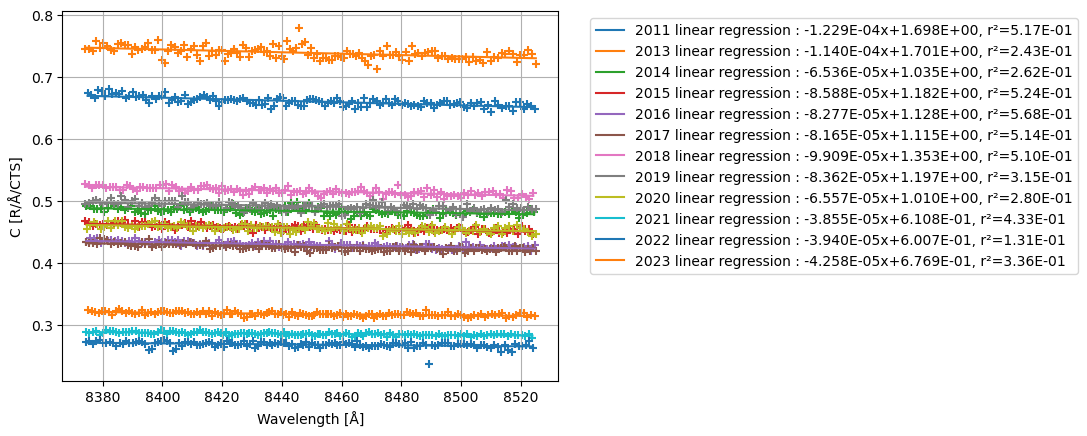

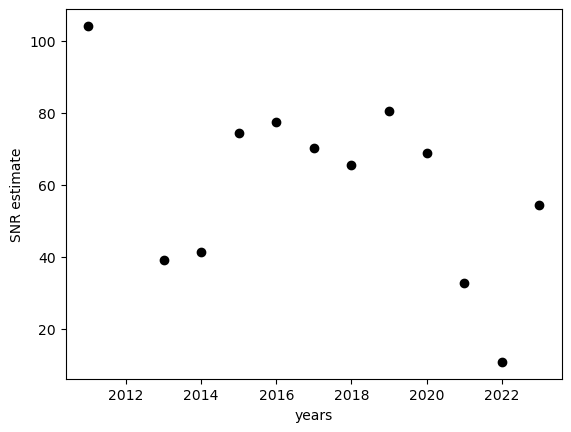

In [6]:
Plot_raw(all_years)

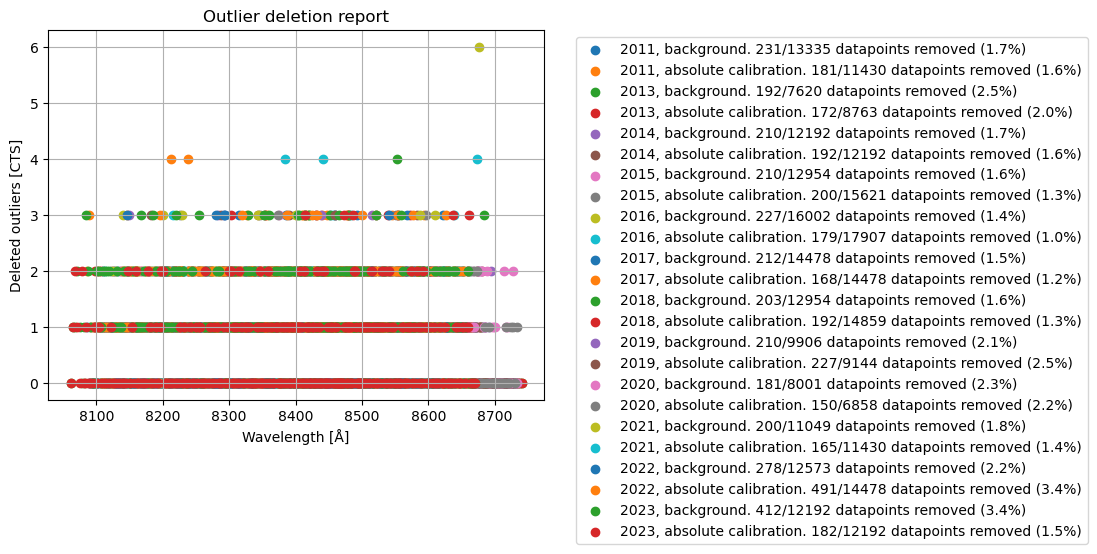

In [7]:
Outlier_report_peirce(all_years)

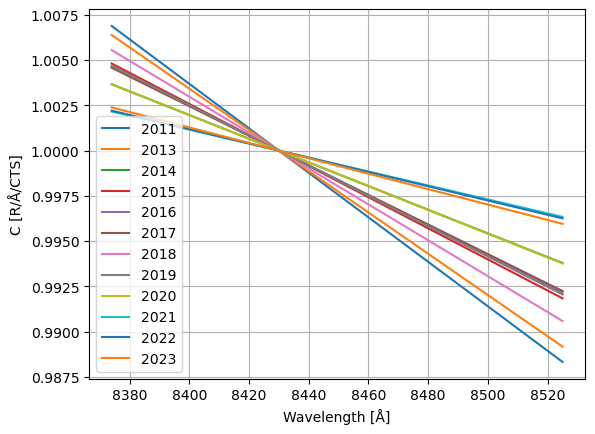

In [8]:
Plot_norm(all_years)

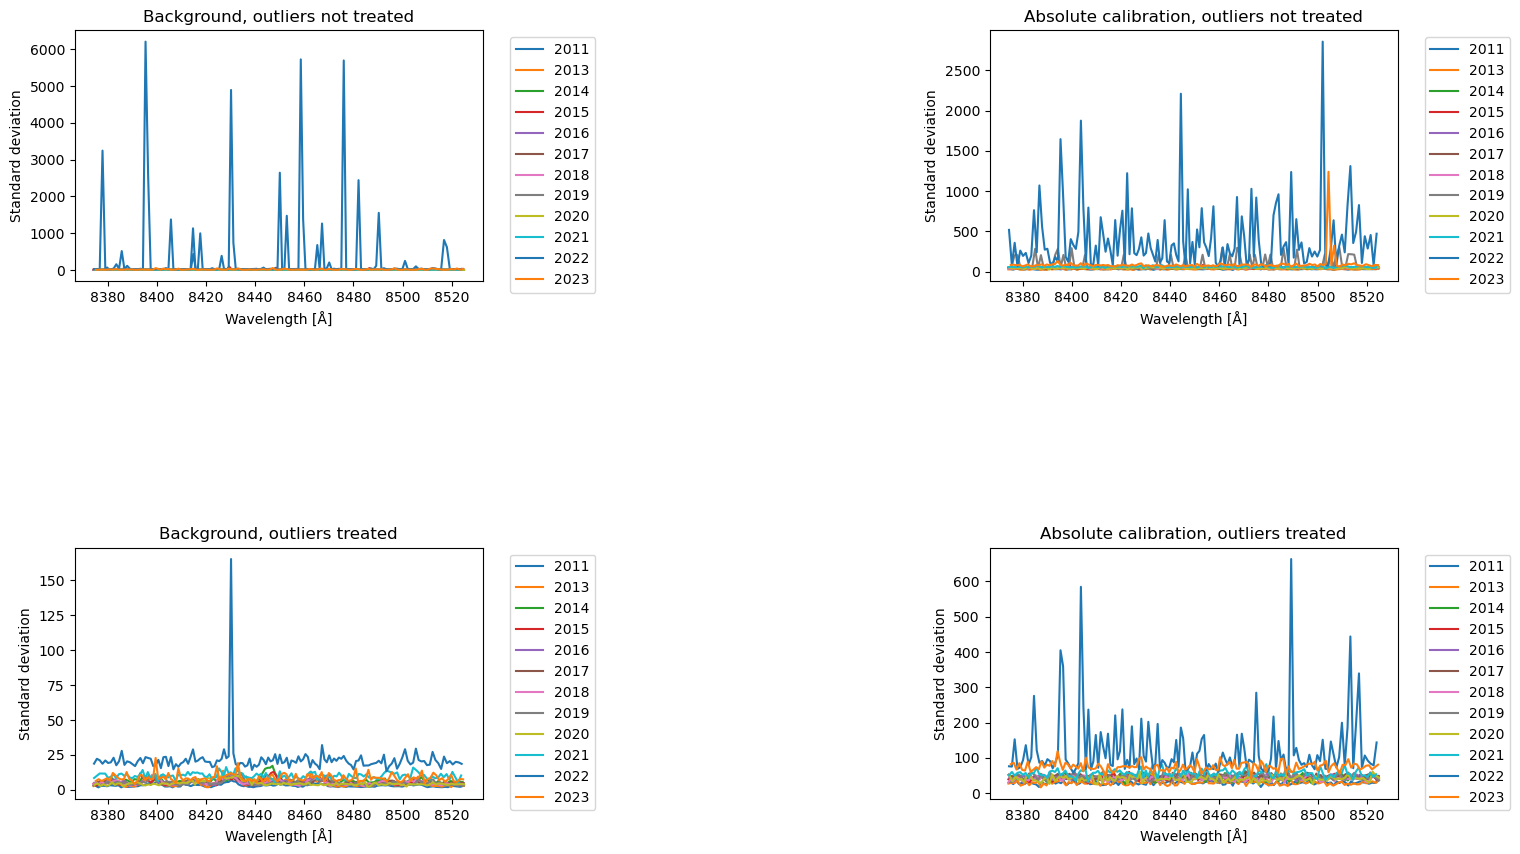

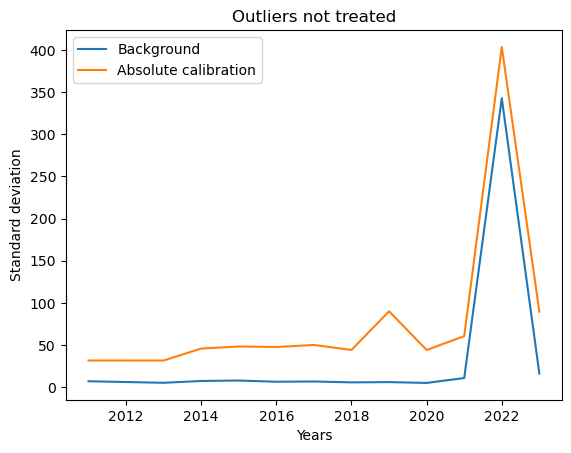

In [9]:
Plot_std(all_years)
#Plot_std([2022,2016])

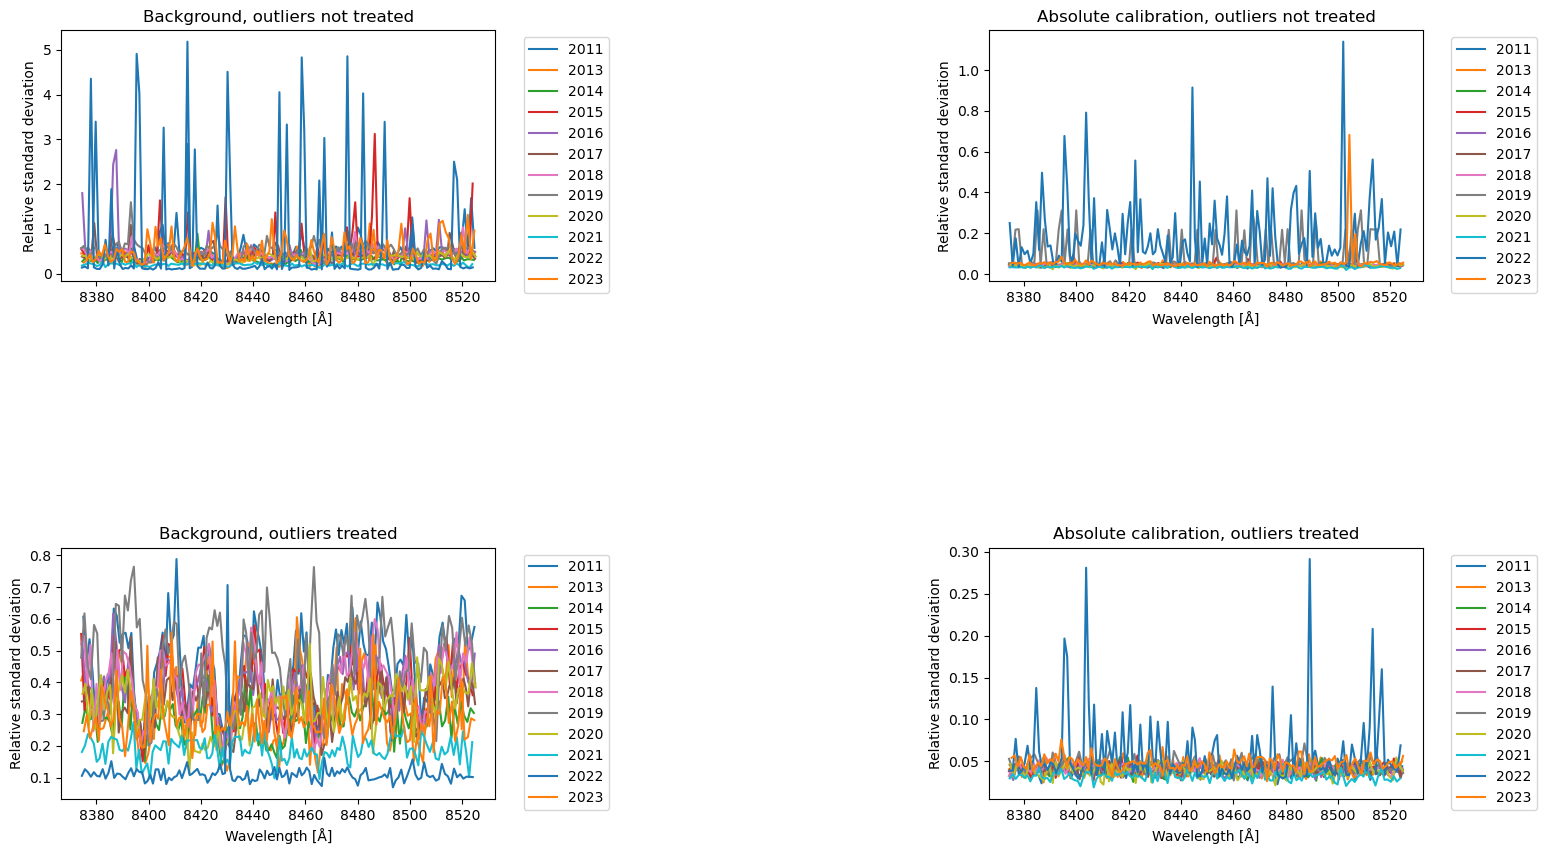

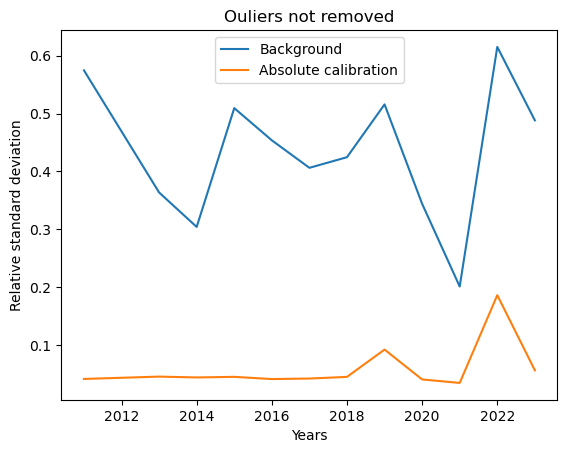

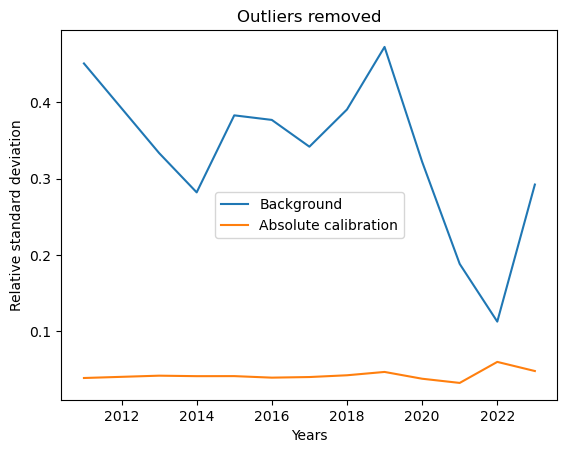

In [10]:
Plot_std_variation(all_years)